Q1: n*_mean = 16, risk = 1.455
Q2: n*_wrst = 25, risk = 4.373
Q3: n*_cvar = 9, risk = 1.499


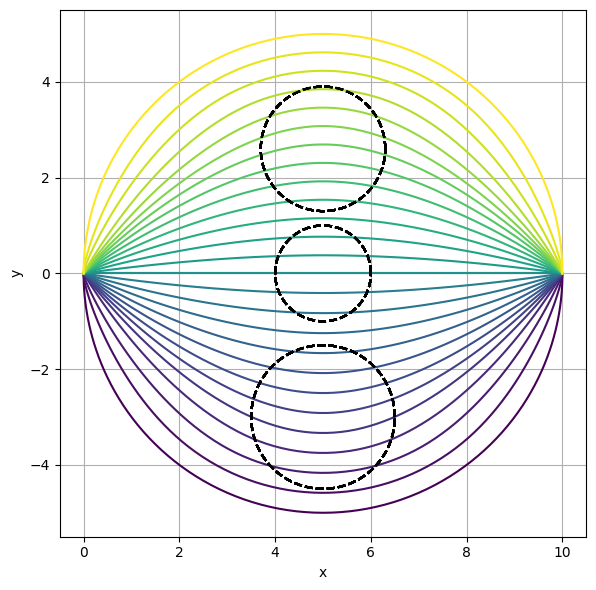

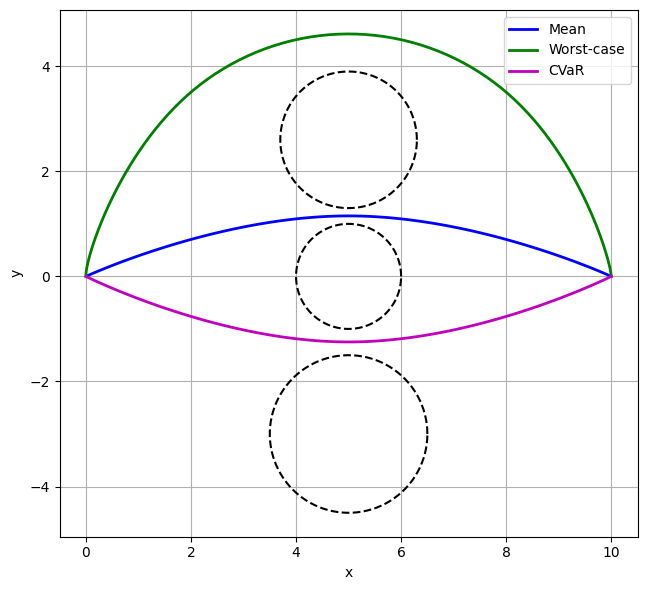

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
HW3 Risk Metrics
- Q1: Expected Mean Risk
- Q2: Worst-Case Risk
- Q3: CVaR-Based Risk
- Q4: Combined Plots and Discussion
Also generates Figure 1: Sampled Trajectories
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# === Load Data ===
trajectories = np.load("data/all_trajectories.npy")  # shape: (N, K+1, 4)
costs = np.load("data/all_costs.npy")                # shape: (N,)

# Obstacles
pos_obs = np.array([[5.0, 0.0], [5.0, 2.6], [5.0, -3.0]])
r_obs = np.array([1.0, 1.3, 1.5])

# Dimensions
N = trajectories.shape[0]
K = trajectories.shape[1]
M = pos_obs.shape[0]

# Uncertainty parameters
sigma = 0.2    # Gaussian noise std-dev for Q3
alpha = 0.3    # CVaR confidence level for Q3
w_worst = 0.6  # worst-case bound for Q2

# Precompute circle for obstacles
theta = np.linspace(0, 2*np.pi, 100)

# === Figure 1: Sampled Trajectories with Obstacles ===
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, N))
for n in range(N):
    traj_n = trajectories[n, :, :2]  # (K+1,2)
    # draw obstacles
    for i in range(M):
        ox, oy = pos_obs[i]
        r = r_obs[i]
        plt.plot(ox + r*np.cos(theta), oy + r*np.sin(theta), 'k--')
    # draw trajectory
    plt.plot(traj_n[:,0], traj_n[:,1], color=colors[n])

plt.gca().set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.savefig("data/fig_sampled_trajectories.pdf")
# plt.show()  # non-interactive backend

# === Risk Metric Calculation: helper for CVaR ===
def compute_lower_cvar(mean_dist, sigma, alpha):
    """
    Lower-tail CVaR for Gaussian: E[d | d <= VaR_lower]
    """
    z_lower = norm.ppf(alpha)
    return mean_dist - (sigma * norm.pdf(z_lower) / alpha)

# === Q1: Expected Mean Risk ===
mean_risks = np.zeros(N)
for n in range(N):
    pos = trajectories[n, :, :2]
    collisions = 0
    for k in range(K):
        for i in range(M):
            if np.linalg.norm(pos[k] - pos_obs[i]) < r_obs[i]:
                collisions += 1
    mean_risks[n] = collisions + costs[n]
n_mean_opt = int(np.argmin(mean_risks))
print(f"Q1: n*_mean = {n_mean_opt}, risk = {mean_risks[n_mean_opt]:.3f}")

# === Q2: Worst-Case Risk ===
worst_risks = np.zeros(N)
for n in range(N):
    pos = trajectories[n, :, :2]
    collisions = 0
    for k in range(K):
        for i in range(M):
            d_nom = np.linalg.norm(pos[k] - pos_obs[i])
            if (d_nom - w_worst) < r_obs[i]:
                collisions += 1
    worst_risks[n] = collisions + costs[n]
n_worst_opt = int(np.argmin(worst_risks))
print(f"Q2: n*_wrst = {n_worst_opt}, risk = {worst_risks[n_worst_opt]:.3f}")

# === Q3: CVaR-Based Risk ===
cvar_risks = np.zeros(N)
for n in range(N):
    pos = trajectories[n, :, :2]
    collisions = 0
    for k in range(K):
        for i in range(M):
            d_nom = np.linalg.norm(pos[k] - pos_obs[i])
            if compute_lower_cvar(d_nom, sigma, alpha) < r_obs[i]:
                collisions += 1
    cvar_risks[n] = collisions + costs[n]
n_cvar_opt = int(np.argmin(cvar_risks))
print(f"Q3: n*_cvar = {n_cvar_opt}, risk = {cvar_risks[n_cvar_opt]:.3f}")

# === Q4: Combined Plot of Optimal Trajectories ===
plt.figure(figsize=(8, 6))
# draw obstacles
for i in range(M):
    ox, oy = pos_obs[i]
    r = r_obs[i]
    plt.plot(ox + r*np.cos(theta), oy + r*np.sin(theta), 'k--')
# draw optimal trajectories
labels = ['Mean', 'Worst-case', 'CVaR']
colors_opt = ['b', 'g', 'm']
indices = [n_mean_opt, n_worst_opt, n_cvar_opt]
for idx, label, col in zip(indices, labels, colors_opt):
    traj = trajectories[idx, :, :2]
    plt.plot(traj[:,0], traj[:,1], color=col, linewidth=2, label=label)

plt.gca().set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("data/fig_optimal_all_trajs.pdf")
plt.show()

# === Discussion ===
# - Mean-risk trajectory hugs obstacles, minimizing average distance.
# - Worst-case trajectory stays farthest to guard against ±0.6m shifts.
# - CVaR trajectory balances occasional large deviations (worst 30%).
# These trade-offs explain the spatial differences among the three optimal paths.
